## Initialize

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
import copy 
import seaborn as sn
import random
import pandas as pd
import seaborn as sns
import numpy as np

import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sklearn
from sklearn.metrics import confusion_matrix
sys.path.append('./third_party')
import pdb
from scipy.stats.mstats import mquantiles
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available? {}".format(torch.cuda.is_available()))

sys.path.append('./codes/')
from bbox import BlackBox
from split_conf import SplitConformal, evaluate_predictions, ProbAccum
from auxiliary import eval_predictions, KL, cvm

# Generate The Data

In [4]:
# pip install xlrd
df = pd.read_excel(r'default_of_credit_card_clients.xlsx')
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [5]:
Y = np.asarray(df.iloc[1:,24]).astype(int)
X_raw = np.asarray(df.iloc[1:,1:24]).astype(np.float32)
X = X_raw

## Set the random seeds

In [6]:
seed = 2
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

X_hout = X_train[int(0.8*X_train.shape[0]):,:]
Y_hout = Y_train[int(0.8*X_train.shape[0]):]

X_train = X_train[:int(0.8*X_train.shape[0]),:]
Y_train = Y_train[:int(0.8*Y_train.shape[0])]

X_tr_score = X_train[int(0.7*X_train.shape[0]):,:]
Y_tr_score = Y_train[int(0.7*X_train.shape[0]):]

X_train = X_train[:int(0.7*X_train.shape[0]),:]
Y_train = Y_train[:int(0.7*Y_train.shape[0])]

X_augmented = np.concatenate((X_train, X_tr_score),0)
Y_augmented = np.concatenate((Y_train, Y_tr_score),0)

num_classes = len(np.unique(Y))
num_features=X_train.shape[1]

## Train the models

In [ ]:
# Train the model with CE loss

refit_model = True

file_final = 'saved_model_orig_'

if refit_model:
    box_ce = BlackBox(num_features, num_classes)
    stats_ce = box_ce.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=500, num_epochs=3000, lr=0.0001, mu=0, optimizer='Adam',
                          save_model=True, save_checkpoint_period = 1,
                          name=file_final, early_stopping=True,
                          name_CP='checkpoint_orig_')
else:
    print('Loading model instead of training')
    box_ce = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_ce.model.load_state_dict(saved_stats['model_state'])
    stats_ce = saved_stats['stats']

In [17]:
# For early stopping loss
box_orig_ho_loss = BlackBox(num_features, num_classes)
saved_stats_ho_loss = torch.load('checkpoint_orig_'+'loss', map_location=device)
box_orig_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_orig_ho_acc = BlackBox(num_features, num_classes)
saved_stats_ho_acc = torch.load('checkpoint_orig_'+'acc', map_location=device)
box_orig_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

In [ ]:
# Train the new black box

refit_model = True
file_final = 'saved_model_new_'

Z_train = np.zeros(len(Y_train))
Z_tr_score = np.ones(len(Y_tr_score))
Z_augmented = np.concatenate((Z_train, Z_tr_score),0)

if refit_model:
    
    box_new = BlackBox(num_features, num_classes)
    stats_new = box_new.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, cond_label=True,
                                Z_train=Z_augmented, 
                                batch_size=2500, num_epochs=6000, lr=0.0001,
                                mu=0.1, mu_size=0, alpha=0.2, optimizer='Adam',
                                save_model=True, save_checkpoint_period = 1,
                                name=file_final, early_stopping=True,
                                name_CP='checkpoint_new_')

else:
    print('Loading model instead of training')
    box_new = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_new.model.load_state_dict(saved_stats['model_state'])
    stats_new = saved_stats['stats']

In [18]:
# For early stopping loss
box_new_ho_loss = BlackBox(num_features, num_classes)
saved_stats_new_loss = torch.load('checkpoint_new_'+'loss')
box_new_ho_loss.model.load_state_dict(saved_stats_new_loss['model_state'])

# For early stopping acc
box_new_ho_acc = BlackBox(num_features, num_classes)
saved_stats_new_acc = torch.load('checkpoint_new_'+'acc')
box_new_ho_acc.model.load_state_dict(saved_stats_new_acc['model_state'])

<All keys matched successfully>

In [ ]:
# Train the hybrid model

file_final = 'saved_model_hybrid_'
refit_model = True

if refit_model:
    box_hybrid = BlackBox(num_features, num_classes)
    stats_hybrid = box_hybrid.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout,
                                Z_train=Z_augmented, cond_label=True,
                                batch_size=2500, num_epochs=4000, lr=0.0001,
                                mu=0, mu_size=0.1, alpha=0.2, 
                                save_model=True, save_checkpoint_period = 1, optimizer='Adam',
                                name=file_final, early_stopping=True, 
                                name_CP='checkpoint_hybrid_', verbose=True)

else:
    print('Loading model instead of training')
    box_hybrid = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_hybrid.model.load_state_dict(saved_stats['model_state'])
    stats_hybrid = saved_stats['stats']

In [21]:
# For early stopping loss
box_hybrid_ho_loss = BlackBox(num_features, num_classes)
saved_stats_hybrid_loss = torch.load('checkpoint_hybrid_'+'loss')
box_hybrid_ho_loss.model.load_state_dict(saved_stats_hybrid_loss['model_state'])

# For early stopping acc
box_hybrid_ho_acc = BlackBox(num_features, num_classes)
saved_stats_hybrid_acc = torch.load('checkpoint_hybrid_'+'acc')
box_hybrid_ho_acc.model.load_state_dict(saved_stats_hybrid_acc['model_state'])

<All keys matched successfully>

In [ ]:
# Train the model with focal loss

file_final = 'saved_model_FocalLoss_'

refit_model = True

if refit_model:
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
    stats_fc = box_fc.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=500, num_epochs=3000, lr=0.0001, mu=0,
                          save_model=True, save_checkpoint_period = 1, optimizer='Adam',
                          name=file_final, early_stopping=True, 
                          name_CP='checkpoint_FocalLoss_', verbose=True)


else:
    print('Loading model instead of training')
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
    saved_stats = torch.load(file_final, map_location=device)
    box_fc.model.load_state_dict(saved_stats['model_state'])
    stats_fc = saved_stats['stats']

In [22]:
# For early stopping loss
box_focal_ho_loss = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_loss = torch.load('checkpoint_FocalLoss_'+'loss', map_location=device)
box_focal_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_focal_ho_acc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_acc = torch.load('checkpoint_FocalLoss_'+'acc', map_location=device)
box_focal_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

## Training diagnostics

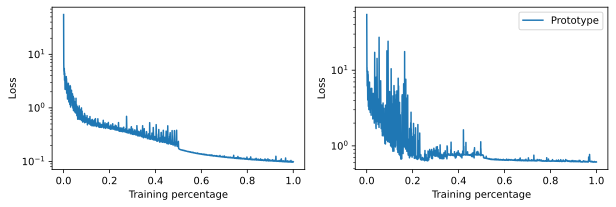

In [20]:
fig=plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["loss"], label="Cross-entropy")
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["loss"], label="Conformal")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.show()

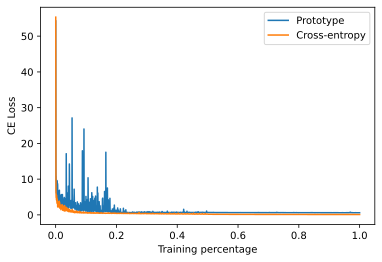

In [21]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["pred"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["pred"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("CE Loss")
#plt.yscale("log")
plt.show()

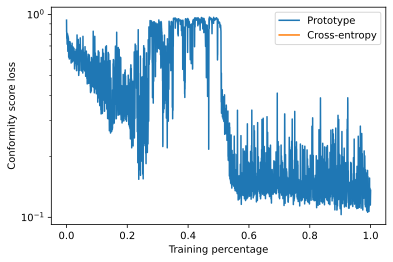

In [22]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["scores"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss")
plt.yscale("log")
plt.show()

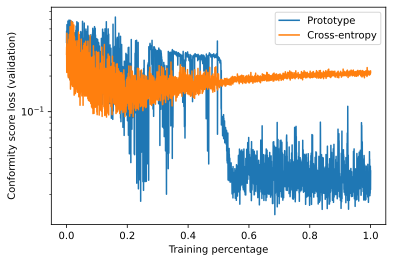

In [23]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["scores-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss (validation)")
plt.yscale('log')
plt.show()

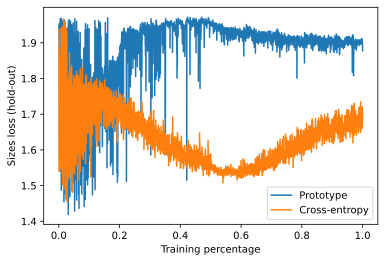

In [24]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["sizes-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["sizes-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Sizes loss (hold-out)")
plt.show()

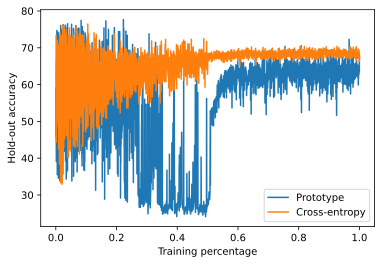

In [25]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["acc-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["acc-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Hold-out accuracy")
plt.show()

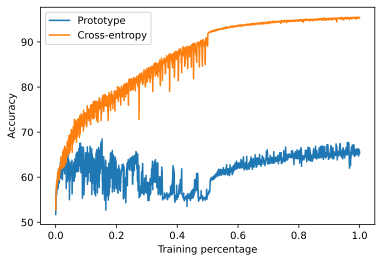

In [26]:
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["acc"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["acc"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Accuracy")
plt.show()

# Check results

## Predictive accuracy

In [ ]:
eval_predictions(X_test, Y_test, box_ce, data="test (CE)")
eval_predictions(X_test, Y_test, box_new, data="test (Conformal)")

## Conformity scores on test data

In [ ]:
bbox_plot = box_ce      # choose bbox to plot histogram of scores

p_hat_test = bbox_plot.predict_proba(X_test)
grey_box = ProbAccum(p_hat_test)
epsilon_test = np.random.uniform(size=(len(Y_test,)))
scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

easy_idx = np.asarray(np.where((Y_test==0)))[0,:]
hard_idx = np.asarray(np.where((Y_test==1)))[0,:]

fig=plt.figure(figsize=(12, 3))
plt.rcParams['font.size'] = '12'
plt.subplot(1, 3, 1)
plt.hist(scores_test)
plt.title("All (n {:d}, CVM {:.2f})".format(len(scores_test), cvm(scores_test)))

plt.subplot(1, 3, 2)
plt.hist(scores_test[hard_idx])
plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))

plt.subplot(1, 3, 3)
plt.hist(scores_test[easy_idx])
plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
plt.show()

## Split-conformal (evaluate)

In [26]:
  black_boxes = [box_ce, box_orig_ho_loss, box_orig_ho_acc, 
                 box_new, box_new_ho_loss, box_new_ho_acc,
                 box_hybrid, box_hybrid_ho_loss, box_hybrid_ho_acc,
                 box_fc, box_focal_ho_loss, box_focal_ho_acc]
  black_boxes_names = ["Cross-entropy", "Cross-entropy ES loss", "Cross-entropy ES acc",
                       "Conformal", "Conformal ES loss", "Conformal ES acc",
                       "Focal", "Focal ES loss", "Focal ES acc",
                       "Hybrid", "Hybrid ES loss", "Hybrid ES acc"]
    

  colors = ["red", "red", "red", "blue", "blue","blue", "yellow", "yellow", "yellow", "black", "black", "black"]

In [ ]:
results = pd.DataFrame()

alpha = 0.2

from tqdm.notebook import tqdm

for e in tqdm(range(25)):

    X_calib, X_test_tmp, Y_calib, Y_test_tmp = train_test_split(X_test, Y_test, test_size=0.5, random_state=e)
    
    easy_idx_calib = np.asarray(np.where((Y_calib==0)))[0,:]
    hard_idx_calib = np.asarray(np.where((Y_calib==1)))[0,:]
    X_calib_hard = X_calib[hard_idx_calib,:]
    X_calib_easy = X_calib[easy_idx_calib,:]
    Y_calib_hard = Y_calib[hard_idx_calib]
    Y_calib_easy = X_calib[easy_idx_calib]
    

    sc_methods = []
    for i in range(len(black_boxes)):
        print("{:s}:".format(black_boxes_names[i]))
        sc_method = SplitConformal()
        sc_method.calibrate(X_calib, Y_calib, alpha, bbox=black_boxes[i], no_calib=False)
        sc_methods.append(sc_method)

    easy_idx = np.asarray(np.where((Y_test_tmp==0)))[0,:]
    hard_idx = np.asarray(np.where((Y_test_tmp==1)))[0,:]

    for k in range(len(black_boxes)):
        sets = sc_methods[k].predict(X_test_tmp)
        res = evaluate_predictions(sets, X_test_tmp, Y_test_tmp, hard_idx, conditional=True)

        res['Model'] = black_boxes_names[k]
        res['Experiment'] = e
        res['Error'] = eval_predictions(X_test_tmp, Y_test_tmp, black_boxes[k], data="test", plot=False)

        results = pd.concat([results, res])

In [ ]:
results.groupby(['Model']).mean()

In [ ]:
sn.reset_orig()
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Conditional coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size (median)')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()